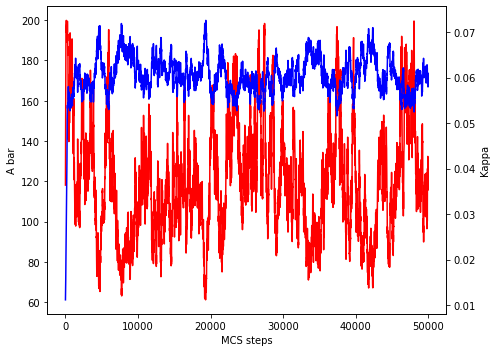

Estimate of A bar: 140.66587369990737
Estimate of Kappa: 0.06349465953142147


In [13]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import scipy.integrate as integrate
from scipy.stats import norm, gamma, uniform

class Mcmc_2D:

    def __init__(self, bounds, displacements, prior_rvs, filename, phys_model):

        # Possible values of random variable X
        self.xbounds  = np.array(bounds[0])
        self.ybounds  = np.array(bounds[1])
        
        
        # Initialize a random number generator
        self.prng     = np.random.default_rng()

        # Max displacements for every degree of freedom
        self.displacements = displacements

        # Store the list of prior random variables as an attribute
        self.prior_rvs = prior_rvs

        # Load measured data from file
        self.z = np.loadtxt(filename)
        
        # The particular equation of the problem written as a function
        self.physical_model = phys_model
    

    def get_log_prior(self,u):
    # chose the prior to be uniformly distributed
        log_prior = 0
    # get the log of the uniform distribution of the prior   
        for i, p_rv in enumerate(self.prior_rvs):
            log_prior += math.log(p_rv.pdf(u[i]))
        
        
        return log_prior

        
    
    def get_log_likelihood(self, u):

        # Computes log likelihood from data
        
        
        log_likelihood  = self.physical_model(self.z,u)
        
        return log_likelihood

    
    

    
    def get_log_posterior(self, u):

        # Get log posterior from log prior and log likelihood

        return self.get_log_prior(u) + self.get_log_likelihood(u)

    
    # Get value of log f at state u where f is the pdf
    def get_log_f_val(self, u):
        
        # Compute log of posterior
        return self.get_log_posterior(u)
    
    # Random walk
    def get_next_pos (self, u_cur):
        
        u_new = np.copy(u_cur)

        # Pick one of the three random variables
        i_var = self.prng.choice(2)

        # Displace this random variable
        u_new[i_var] = u_cur[i_var] + self.displacements[i_var]*self.prng.uniform (low = -1, high = 1)
        
        return u_new
        
    def make_plot(self, states):

        # Makes a plot of the trajectory
        
        fig, ax1 = plt.subplots(figsize = (7,5))

        ax2 = ax1.twinx()
        
        n, a = states.shape
        
        ax1.plot(10*np.arange(n)+1, states[:,0], color = "r")
        ax2.plot(10*np.arange(n)+1, states[:,1], color = "b")
        
        ax1.set_ylabel("A bar")
        ax2.set_ylabel("Kappa")
        ax1.set_xlabel('MCS steps')

        plt.tight_layout()
        #plt.savefig('trajec.pdf')
        plt.show()
        
    def check_bounds(self, u_cur):

        # Returns False if walker is out of bounds
        
        if u_cur[0] > self.xbounds[-1] or u_cur[0] < self.xbounds[0]:
            return False
        
        if u_cur[1] > self.ybounds[-1] or u_cur[1] < self.ybounds[0]:
            return False

        
        return True
    
    def run_mc(self, u0, nsteps = 200):

        # Main MC loop
        u_old          = np.array(u0, dtype = np.float64)
        
        states = []
        parameter1 = []
        parameter2 = []
        
        for istep in range(nsteps):

            # Compute f at current u
            log_f_old = self.get_log_f_val(u_old)

            # Propose a new u
            u_new  = self.get_next_pos (u_old)

            # Reject the move if bounds are exceeded
            if not self.check_bounds(u_new):
                continue
            
            # Compute f at new u
            log_f_new = self.get_log_f_val (u_new)

            del_log_f = log_f_new - log_f_old
            
            # Compute acceptance factor
            # if del_log_f is larger than zero accenptance factor will be one

            if del_log_f > 0:
                acc_factor = 1
            else:
                acc_factor = math.exp(log_f_new - log_f_old)

            # Proposal probabilities are equal both ways

            # Accept/Reject proposal
            if (self.prng.random() <= acc_factor):

                # Update position
                u_old = u_new
            
            # Create empty lists to store values of a bar and inverse kappa at each state
            
            
            if ((istep+1) % 10 == 0):
                states.append(u_old)
                parameter1.append(u_old[0])
                parameter2.append(u_old[1])
                #print('MC Step # : ',istep + 1, ' Parameter: ', u_old)
            #print(u_old)
        
        self.make_plot(np.array(states))
                


        # Return the lists of values of the two parameters
        return parameter1, parameter2
    

if __name__=='__main__':

    # u is an array u[0] is a and u[1] is b
    def particle_likelihood(z, u):
    # Boltzmann's constant
        k_b = 1.38e-23
    # Temperature in kelvin
        T = 300
    # Density difference
        density_diff = 960
    # radius of particle
        radius = 1.0e-6
    # net bouyant weight
        G = (density_diff * (4/3) * math.pi * (radius**4) * 9.8)/(k_b * T)

        repulsion = u[0] * np.exp(-z/u[1])

        attraction = G*z
 # Computing the denominator numerically
        get_pl = lambda y : u[0] * math.exp(-y/u[1]) + G*y
        result = integrate.quad(lambda x: math.exp(-get_pl(x)), 0, 10)
 # Upper limit is set as 10 and not infinity
 # This gives an accurate enough estimate
        return -np.sum((repulsion + attraction)) - (z.size*math.log(result[0]))

    # Priors on three parameters a, b and sigma
    # Define two random variables    
    # Change them to the A and k bar
    rv_a = uniform(loc = 50, scale = 150)
    rv_b = uniform(loc = 0.010, scale = 0.090)
    
    # List of prior random variables
    priors = [rv_a, rv_b]
    
    # Range of each parameter
    bounds = [[50,200],[0.01, 0.100]]

    # Maximum displacement for each parameter
    disps = [10, 0.001]
    
    # Create a Mcmc_3D object
    mcmc_obj = Mcmc_2D(bounds, disps, priors, 'expt_obs.dat', particle_likelihood)

    # Run length
    nsteps   = 50000

    # Run mcmc trajectory and get the lists of parameters
    a,b = mcmc_obj.run_mc([100, 0.01], nsteps)
    
    # Sort the lists
    a.sort()
    b.sort()
    
    # Delete the first 50%percent of the list and return the average
    a , b = a[(int(len(a)*0.5)):] , b[(int(len(b)*0.5)):]
    
    # Calculate expectation by calculating average of the list
    print("Estimate of A bar:", sum(a)/len(a))
    print("Estimate of Kappa:",sum(b)/len(b))

    
    
    
    
    
